In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras

In [5]:
#PRETRAINED MODEL
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

#Iz tfds ucitaj bazu cats_vs_dogsi podeli ih na osnovu sledecih parametara, i stavih ih u raw_* fajlove
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', "train[80%:90%]", "train[90%:]"],
    with_info=True,
    as_supervised=True
)

Dataset cats_vs_dogs downloaded and prepared to C:\Users\Teodor Petrovic\tensorflow_datasets\cats_vs_dogs\4.0.0. Subsequent calls will reuse this data.


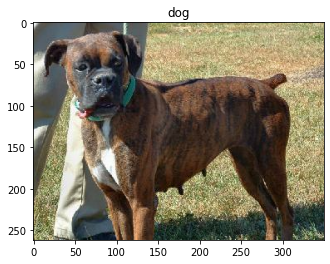

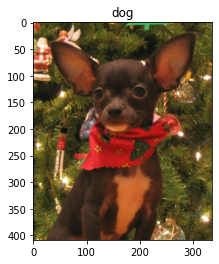

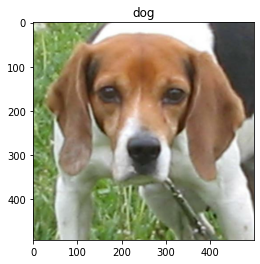

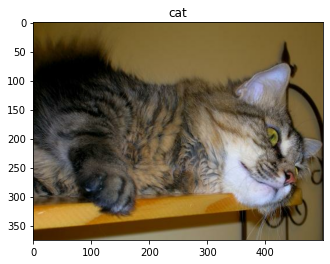

In [9]:
#Funkcija koju koristimo da bismo dosli do labela bilo koje slike
get_label_name = metadata.features['label'].int2str

#Prikazi n broj slika iz trening skupa
for image, label in raw_train.take(4):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

In [10]:
#Kao sto mozemo ovde da vidimo nisu sve slike istih dimenzija, tj mi cemo moradi da ih promenimo,
#tako da su sve slike standarizovane

img_size = 160 #Slike ce biti dimenzija 160X160 i uvek je bolje da se slike kompresuju smanje nego da se rastegnu tj povecaju

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) -1
    image = tf.image.resize(image, (img_size, img_size))
    
    return image, label

In [11]:
train = raw_train.map(format_example) # map funkcija, na svakog clana nekog skupa primenjuje odredjenu funkciju
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

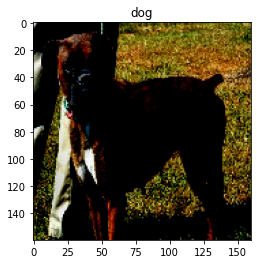

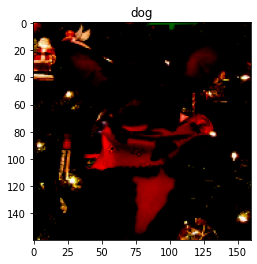

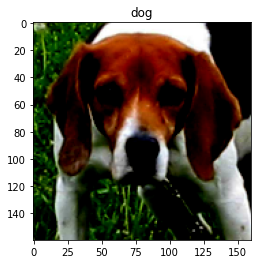

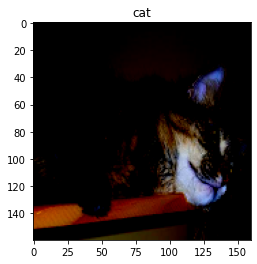

In [17]:
#Prikazi n broj slika iz trening skupa
for image, label in train.take(4):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

In [29]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [15]:
for img, label in raw_train.take(2):
    print("Original shape:", img.shape)
for img, label in train.take(2):
    print("New Shape:", img.shape)

Original shape: (262, 350, 3)
Original shape: (409, 336, 3)
New Shape: (160, 160, 3)
New Shape: (160, 160, 3)


In [18]:
#Sada biramo pretrained model 

img_shape = (img_size, img_size, 3)

#Ucitavamo nas model, govorimo mu koji input shape nase podaci ce biti, da li da ubaci sve clase koje on ima (U ovom slucaju 100, tj Necemo)
#I koje tezine grana da ucita
base_model = tf.keras.applications.MobileNetV2(
    input_shape=img_shape,
    include_top=False,
    weights="imagenet"
)

9420800/9406464 [==============================] - 1s 0us/step


In [19]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [20]:
#Freezing the Base
#Predstavlja da mi nezelimo da menjamo tezine naseg NN tj. modela koji smo skinuli,
#jer on vec ima bolje tezine jer je istreniran na 2,5 miliona slika koje mi ne mozemo,
#tako brzo da treniramo
base_model.trainable = False

In [21]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [22]:
#Sada dodajemo nase klasifikatore

#Daje nam srednju vrednost svih 1280 5x5 filtera 
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [24]:
#Na kraju dodajemo samo jedan Dense sloj, koji ce da nam daje neke vrednosti, mozemo ga ovako napraviti 
#jer imamo samo dve vrednosti [Cat, Dog] [0, 1]
prediction_layer = keras.layers.Dense(1)

In [25]:
#Dodajemo ga modelu
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [27]:
#Sada treniramo poslednja dva sloja

#Ne zelimo da pomeramo tezine puno, zato sto je vec istreniran model
base_learning_rate = 0.001 # Stepen ucenja, za koliko mogu da modifikujem tezine (w) i biase (b) u mom modelu
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

C:\Users\Teodor Petrovic\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [30]:
#Prvo cemo ga evaluirati pre treninga da vidimo koje rezultate daje, jer je model vec istreniran
initial_epochs = 3
validation_steps = 20

loss0, accuracy0 = model.evaluate(validation_batches, steps= validation_steps)

20/20 [==============================] - 8s 335ms/step - loss: 0.7842 - accuracy: 0.4906


In [31]:
#Sada treniramo model, sa nasim slikama
history = model.fit(
    train_batches,
    epochs=initial_epochs,
    validation_data=validation_batches
)

acc = history.history["accuracy"]
print(acc)

Epoch 1/3
582/582 [==============================] - 257s 435ms/step - loss: 0.0718 - accuracy: 0.9722 - val_loss: 0.0481 - val_accuracy: 0.9815
Epoch 2/3
582/582 [==============================] - 236s 403ms/step - loss: 0.0432 - accuracy: 0.9837 - val_loss: 0.0480 - val_accuracy: 0.9841
Epoch 3/3
582/582 [==============================] - 244s 417ms/step - loss: 0.0392 - accuracy: 0.9853 - val_loss: 0.0450 - val_accuracy: 0.9837
[0.9721655249595642, 0.9836646914482117, 0.9853304624557495]


In [37]:
loss1, accuracy1 = model.evaluate(validation_batches, steps= validation_steps)


20/20 [==============================] - 7s 319ms/step - loss: 0.0521 - accuracy: 0.9766


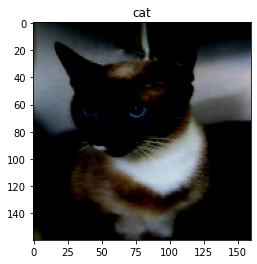

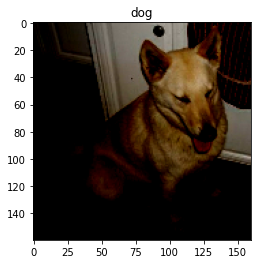

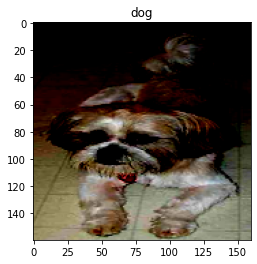

In [49]:
i = 1

for image, label in test:
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))
    
    i += 1
    if i > 3:
        break

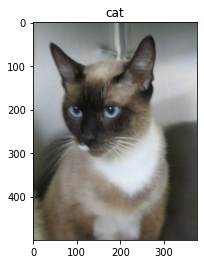

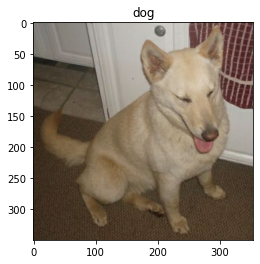

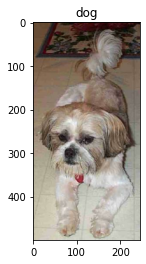

In [52]:
for image, label in raw_test.take(3):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

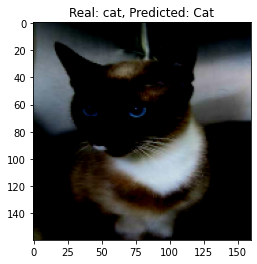

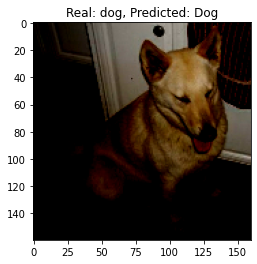

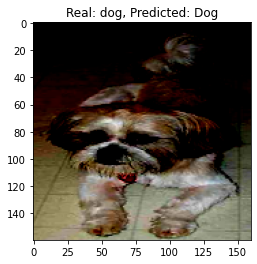

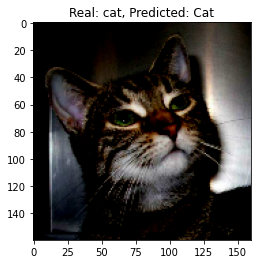

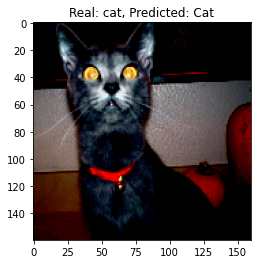

In [73]:
pic_num = 1

class_name = ["Cat", "Dog"]

prediction = model.predict(test_batches)
#print(prediction.shape)
#print(prediction.max())
#print(prediction.mean())
#print(prediction.min())

i = 0
predLabel = ""

for image, label in test.take(5):
    
    if prediction[i] > 0:
        predLabel ="Dog"
    else:
        predLabel ="Cat"
    plt.figure()
    plt.imshow(image)
    plt.title("Real: " + get_label_name(label) + ", Predicted: " + predLabel)
    
    i += 1


In [33]:
model.save("dogs_vs_cats.h5")

In [34]:
new_model = tf.keras.models.load_model("dogs_vs_cats.h5")

In [ ]:
#Object detection